# Lab 3: Neural Tangent Kernel

The goal of this lab is to compute by hand a neural tangent kernel.

## Non-linear regression with a neural network

Generate the dataset and visualize it.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np

In [2]:
random_seed = 3455
torch.manual_seed(random_seed)

In [3]:
wtrue = torch.tensor([0.1]).view(1,1) 

### Question: generate the training samples.

Generate $N=4$ values $x_i$'s in $[-35,35]$ that are uniformly distributed. Generate the labels $y_i$ such that

$$
y_i = sigmoid(w^* x_i)
$$

with $w^*=0.1$ and "sigmoid" is the sigmoid function $\sigma(t)=1/(1+e^{-t})$.

Generate $N$ other samples that will be used as a test set.

In [4]:
# Complete the cell

In [5]:
# Make data
N = 4 
d=1 # input dimension

# Training set
# uniform samples between -35 and 35 
x = 70*(torch.rand(N, d)-0.5)
y = torch.sigmoid(x.mm(wtrue))

# Test set
xtest = 70*(torch.rand(N, d)-0.5)
ytest = torch.sigmoid(xtest.mm(wtrue))

### Question: plot the training samples.

Plot the training dataset and test dataset

In [6]:
# Complete the cell

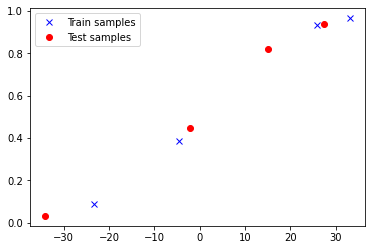

In [7]:
plt.plot(x.numpy(),y.numpy(),'bx', label='Train samples')
plt.plot(xtest.numpy(),ytest.numpy(),'ro', label='Test samples')
plt.legend()
plt.show()

## Implementation of the Neural network 

### Question: implement a ReLU neural network with a single hidden layer. You can use 100 hidden neurons. The goal of the neural network is to estimate the labels considered as some real values (it is a regression problem, not a classification one).

In [8]:
# Complete the cell

In [9]:
# D_in is input dimension;
# H is hidden dimension; 
# D_out is output dimension.
D_in = 1 
H = 100
D_out = 1

# Use the nn package to define our model as a sequence of layers. nn.Sequential
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out, bias=True),
)

print(model)

# save the model to learn the NTK later
torch.save(model, "model0.pt")


Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)


### Question: define an Adam optimizer and the appropriate loss function.

In [10]:
# Complete the cell

Define the optimizer and the loss function

In [11]:
learning_rate = 1e-6
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# We will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='mean')

## Train the neural network

### Question: train the neural network with the Adam optimizer.

In [12]:
# Complete the cell

In [13]:
N_iter = 5*10**4 
L = np.zeros(N_iter) 
Ltest = np.zeros(N_iter)

for t in range(N_iter):
    # Forward pass
    y_pred = model(x)

    # Compute and print loss. 
    loss = loss_fn(y_pred, y)
    L[t] = loss.item() # save the loss
    if t % 1000 == 0:
        print(t, loss.item())

    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Compute the test loss
    ytest_pred = model(xtest)
    loss_test = loss_fn(ytest_pred, ytest)
    Ltest[t] = loss_test.item() # save the test loss

0 0.17030197381973267
1000 0.08496222645044327
2000 0.08062099665403366
3000 0.07811101526021957
4000 0.07503014802932739
5000 0.07139910757541656
6000 0.06727483123540878
7000 0.06277506053447723
8000 0.05805159732699394
9000 0.05326031148433685
10000 0.04853488877415657
11000 0.043964605778455734
12000 0.03959726169705391
13000 0.03545108437538147
14000 0.031534790992736816
15000 0.02785556949675083
16000 0.024416210129857063
17000 0.02121579274535179
18000 0.018229307606816292
19000 0.015477310866117477
20000 0.01297721266746521
21000 0.010719895362854004
22000 0.008699631318449974
23000 0.006918265949934721
24000 0.005374819040298462
25000 0.004054149612784386
26000 0.002951413858681917
27000 0.002059006132185459
28000 0.0013671193737536669
29000 0.0008609687793068588
30000 0.0005198068101890385
31000 0.0003134858561679721
32000 0.00020032489555887878
33000 0.0001369544625049457
34000 9.179085463983938e-05
35000 5.693938146578148e-05
36000 3.152190402033739e-05
37000 1.476455599913

### Question: plot the training loss and the test loss. Comment briefly the convergence of the training. You can adjust the learning rate to improve the loss if necessary.

In [14]:
# Complete the cell

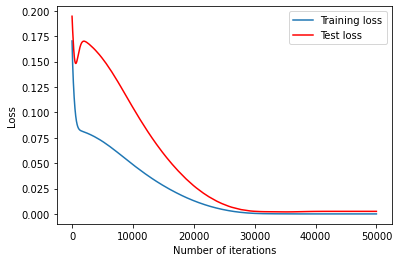

In [15]:
plt.plot(np.arange(N_iter),L, label='Training loss')
plt.plot(np.arange(N_iter),Ltest,'r-', label='Test loss')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Question: write a Pytorch function with inputs "x", "y" and "y_pred" that plots the predicted labels "y_pred" and the ground-truth labels "y" with respect to "x". The goal is to analyse visually the quality of the learning. Use this function two times to plot the neural network approximation for 1) the training samples and 2) the test samples.

In [16]:
# Complete the cell

Function that plots the approximation and the ground truth

In [17]:
def plotApproximation(x,y,y_pred):
  plt.figure(figsize=(6, 4))
  plt.plot(x.detach().numpy(),y.detach().numpy(),'bx', label='Ground truth')
  plt.plot(x.detach().numpy(),y_pred.detach().numpy(),'r*', label='Predicted values')
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.title('Approximation with the neural network')
  plt.legend()
  plt.show()

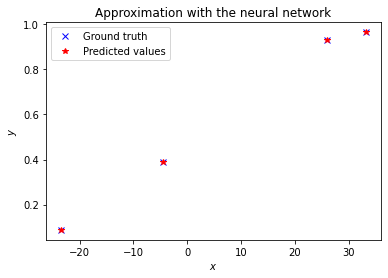

In [18]:
plotApproximation(x,y,y_pred)

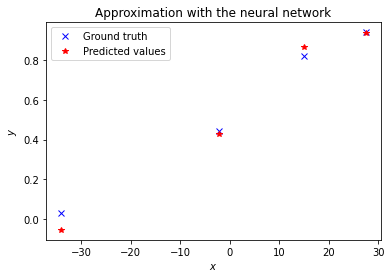

In [19]:
plotApproximation(xtest,ytest,ytest_pred)

## Study of the NTK

### Question: use autograd to compute the Jacobian matrix that is necessary to compute the neural tangent kernel. You will write a function "computeJacobian(x, model)" whose inputs are "x" and the neural network model "model".

In [20]:
# Complete the cell

Compute the Jacobian matrix of the model (i.e., the function)

In [21]:
def computeJacobian(x, model):
    J = torch.zeros(N,3*H+1)
    for t in range(N):
        y_pred = model(x[t,:])
        model.zero_grad()
        y_pred.backward()
        # Get the gradients
        grad1 = model[0].weight.grad.view(1,H).clone()
        grad1b = model[0].bias.grad.view(1,H).clone()
        grad2 = model[2].weight.grad.view(1,H).clone()
        grad2b = model[2].bias.grad.view(1,1).clone()
        grad_x = torch.cat((grad1, grad1b, grad2, grad2b), 1)
        J[t,:]=grad_x.clone() # create the Jacobian by concatenating the gradient vectors
    return(J)

### Question: compute the NTK matrix $K_0$ before the training. You can save the model before the training and load it here to compute the NTK.

In [22]:
# Complete the cell

Compute the NTK at time 0 at its rank

In [23]:
model0 = torch.load("model0.pt")

J0 = computeJacobian(x, model0)
K0 = J0.mm(J0.T)/N
print(K0.shape)
print(torch.linalg.matrix_rank(K0).item())

torch.Size([4, 4])
4


### Question: compute the NTK $K^*$ after the training.

In [24]:
# Complete the cell

In [25]:
Jstar = computeJacobian(x, model)
Kstar = Jstar.mm(Jstar.T)/N
print(Kstar.shape)
print(torch.linalg.matrix_rank(Kstar).item())

torch.Size([4, 4])
4


### Question: check the difference between the NTK $K_0$ before the training and the NTK $K^*$ after the training. Compute the relative change between the NTKs with respect to the Frobenius norm.

In [26]:
# Complete the cell

Compute the relative change (percentage) between K0 and K after training

In [27]:
print(torch.norm(K0-Kstar,'fro')/torch.norm(K0,'fro')*100)

tensor(0.0929)


In [28]:
print(K0)

tensor([[ 2.4831e+03,  7.8008e-02,  3.1618e+03,  2.2568e-01],
        [ 7.8008e-02,  2.3320e+03, -2.5116e-02,  4.7629e+02],
        [ 3.1618e+03, -2.5116e-02,  4.0263e+03,  1.6894e-01],
        [ 2.2568e-01,  4.7629e+02,  1.6894e-01,  9.9860e+01]])


In [29]:
print(Kstar)

tensor([[2.4839e+03, 2.5000e-01, 3.1626e+03, 1.6682e-01],
        [2.5000e-01, 2.3380e+03, 2.5000e-01, 4.7727e+02],
        [3.1626e+03, 2.5000e-01, 4.0273e+03, 1.2433e-01],
        [1.6682e-01, 4.7727e+02, 1.2433e-01, 1.0009e+02]])


### Question: use the feature $\phi(x)$ deduced from the NTK $K_0$ to learn a kernel linear regression. The linear regression will be trained with sklearn "LinearRegression()".

Compute the linear regression with kernel with sklearn

In [30]:
from sklearn import linear_model

In [31]:
# Complete the cell

Linear regression regression with "J0" the features deduced from $K_0$.

Following the lecture, the linear model is

$$
f(x,\theta) \approx f(x,\theta_0)+D_\theta f(x,\theta_0) (\theta-\theta_0)=f(x,\theta_0)+D_\theta f(x,\theta_0)^T \omega,
$$

where $f(x,\theta)$ denotes the neural network with input $x$ and parameter vector $\theta$.

The linear regression goal is to estimate $\omega=\theta-\theta_0$.
For a given $x$, the non-linear feature is $D_\theta f(x,\theta_0)$.

In [32]:
Phi0X = J0.detach().numpy() # Input nonlinear features
reg0 = linear_model.LinearRegression()
f_x0 = model0(x).detach().numpy()
reg0.fit(Phi0X, y-f_x0)


# Size of the learned parameters
print(reg0.coef_.shape)
print(reg0.intercept_.shape)

(1, 301)
(1,)


### Question: Compare the results with the kernel linear regressions deduced from $K_0$ and $K^*$. You must train the two regression models and evaluate them with the training set.

In [33]:
# Complete the cell

Prediction with the feature deduced from $K_0$.

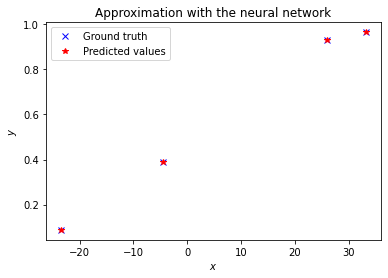

In [34]:
reg0_y_pred = torch.from_numpy(reg0.predict(Phi0X))+f_x0
plotApproximation(x,y,reg0_y_pred)

Prediction with the feature deduced from $K^*$.

In [35]:
PhiX = Jstar.detach().numpy() # Input nonlinear features
f_x = model(x).detach().numpy()
reg = linear_model.LinearRegression()
reg.fit(PhiX, y-f_x)
# Compute the prediction
reg_y_pred = torch.from_numpy(reg.predict(PhiX))+f_x


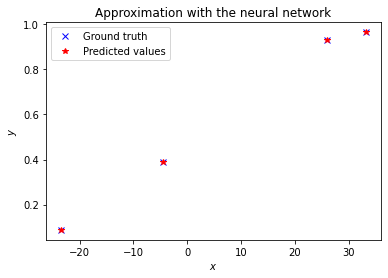

In [36]:
plotApproximation(x,y,reg_y_pred)

### Question: Compare the results with the kernel linear regressions deduced from $K_0$ and $K^*$. You must evaluate them with the test set.

In [37]:
# Complete the cell

Compute the prediction of the test samples

In [38]:
J0test = computeJacobian(xtest, model0).detach().numpy()
f_xtest0 = model0(xtest).detach().numpy()

Jtest = computeJacobian(xtest, model).detach().numpy()
f_xtest = model(xtest).detach().numpy()

reg0_ytest_pred = torch.from_numpy(reg0.predict(J0test)+f_xtest0)
reg_ytest_pred = torch.from_numpy(reg.predict(Jtest)+f_xtest)

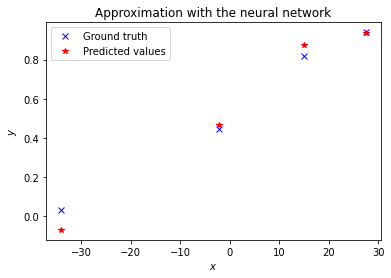

In [39]:
plotApproximation(xtest,ytest,reg0_ytest_pred)

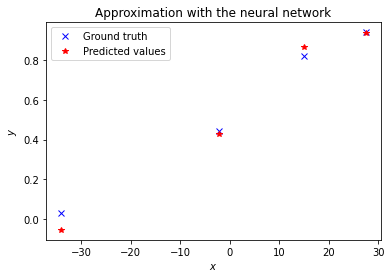

In [40]:
plotApproximation(xtest,ytest,reg_ytest_pred)